***This Layout was used based on Jason Brownlee's layout from his book (Machine learning Mastery)*** 😊
[Machine Learning Mastery with Python](https://machinelearningmastery.com/machine-learning-with-python/)

This Notebook includes my methodology to tackle the problem of **Gender-Based Violence Tweet Classification Challenge**👧🧒 at Zindi website.

[GBV](https://zindi.africa/competitions/gender-based-violence-tweet-classification-challenge)

# 1- Prepare Problem

## a) Load libraries

In [ ]:
import tensorflow as tf
# import tensorflow_addons as tfa
# import sklearn
import re
import nltk
from nltk import word_tokenize
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
porter = PorterStemmer()
import h5py
from tensorflow.keras import backend as K
import keras
import os
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import matplotlib.image as mpimg
import numpy as np
import tensorflow_datasets as tfds
import multiprocessing
from multiprocessing.pool import ThreadPool
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import random as python_random
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score
from wordcloud import WordCloud
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(123)

## b) Load dataset

In [ ]:
# A variable to store file's directory
dir = ''
df_train = pd.read_csv(dir)

# To get the first 5 rows pf data
df_train.head(5)

# 2- Summarize Data

## a) Descriptive statistics

In [ ]:
df_train.info()

It can be observed that there is problems related to this dataset:
1. The 'type' column name isn't appropriate since it is confusing user, as Python has type as a function.

2. modify 'Tweet_ID' column.

3. Data types of columns aren't defined well, tweets should be strings and also the type of tweet or its class should be defined as a string or category.

4. the "Harmful_Traditional_Practice" should be modidified by lowering the first capital letter of each word.

5. Classes should be encoded in a proper way.

6. Text data should be cleaned before modeling.

In [ ]:
# Total Number of samples
print(len(df_train))

In [ ]:
# To get the classes' number of samples
print(df_train['type'].value_counts())

We can notice severe class imbalance, that should be treated using oversampling, undersampling or cost sensitive analysis techniques.

In [ ]:
# Finiding tweet lengths
tweet_len = df_train.tweet.str.len()
print(tweet_len.head())

In [ ]:
# Finiding the minimum and maximum tweet lengths
print('The maximium length: {}, The minimum length: {}, The mean lenght: {}'.format(tweet_len.max(),  
                                                                                    tweet_len.min(),  
                                                                                    tweet_len.mean()))

In [ ]:
# Check for any Null data
print(df_train.isnull().any())

## b) Data visualization

Here we want to answer some questions like: 


1.   The distribuition of classes visually.
2.   Tweet length distribuition.
3.   Word clouds generated for each violent class.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Classes distribution')

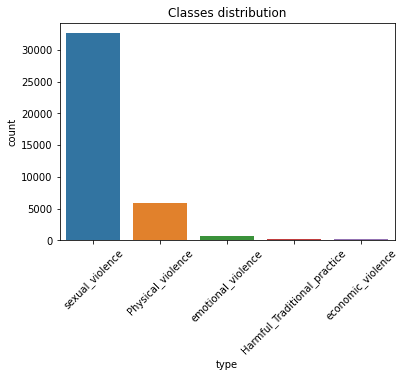

In [ ]:
# Visual inspection of classes' distribution
ax = sns.countplot(df_train['type'], orient='v')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title('Classes distribution')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'Length'), Text(0.5, 1.0, 'Tweet lengths distribution')]

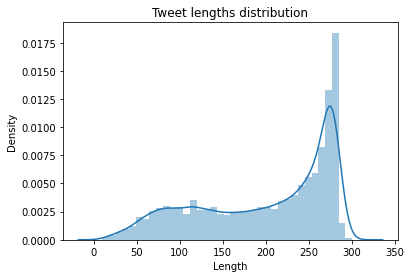

In [ ]:
# Tweet Length distribuition
sns.distplot(tweet_len).set(title='Tweet lengths distribution', xlabel = 'Length')

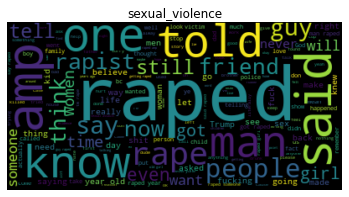

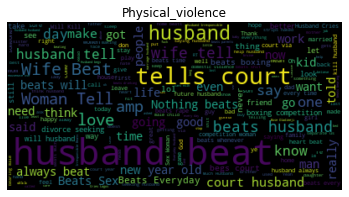

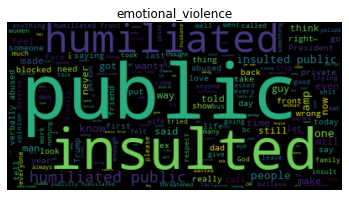

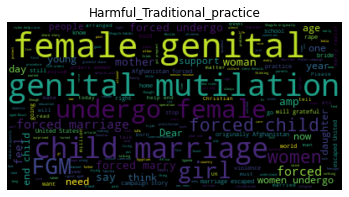

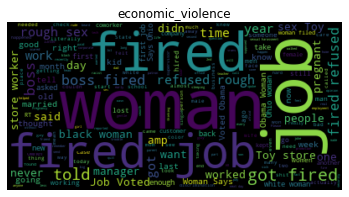

In [ ]:
# Building Word-Cloud in order to be able to visualize the most frequent words in each violent category.
sentiment = list(df_train['type'].unique())

for i in sentiment:
  violence = df_train[df_train['type'] == i]

# To concatenate strings with a specific separator
  violence_string = pd.Series(violence.tweet).str.cat(sep=' ')
  violence_string = WordCloud().generate(violence_string)
  plt.imshow(violence_string, interpolation='bilinear')
  plt.axis('off')
  plt.title(i)
  plt.show()

***It should be noted at *Sexual_violence*, *Emotional_violence* and *economic_violence* categories have "amp" word which should be removed before modeling through preprocessing***

# 3- Prepare Data

## a) Data cleaning

Our trials will be:


1.  With no cleaning, just using raw data.
2.  Using basic pre-processing such as: removing punctuation, normalizing words by lowering.
3.  Same as step (2) but we will add removing english stop words.
4.  Using stemming and lemmatisation.



My cleaning function

In [ ]:
def clean_data(tweets_col, token = True, stemming = False, punc = False, stp_words = False,  noemoji = False):
  """
  A function used to clean tweets before converting to numerical values for modelling.

  Args:-

  tweets_col: the column which contains the tweet text at the dataframe.
  token:      bool, default = True, to activate the tokenization operation.
  stemming:   bool, default = False, to stem each tokenized word.
  punc:       bool, default = False, to remove punctuation from tokenized text.
  stp_words:  bool, defualt = False, to remove stopwords from text.
  noemoji:    bool, default = False, to remove emojis and special characters
  
  

  return:-

  cleaned_tweets: list, a list that contains tweets' text after cleaning
  """

  if token:
    tokened_tweets = [word_tokenize(word) for word in tweets_col]
    print('Tokenized sentence:{}'.format(tokened_tweets[1]))
    cleaned_tweets = [' '.join(i) for i in tokened_tweets]

  if stemming == True:
    stemmed_tokens = [[porter.stem(word) for word in item] for item in tokened_tweets]
    print('stemmed sentence:'.format(stemmed_tokens[1]))
    cleaned_tweets = [' '.join(i) for i in stemmed_tokens]  

  if punc == True:
    nopunc_tokens = [[word for word in item if word.isalpha()] for item in tokened_tweets]
    print('no puncutation sentence:{}'.format(nopunc_tokens[1]))
    cleaned_tweets = [' '.join(i) for i in nopunc_tokens]

  if stp_words == True:
        stop_words = set(stopwords.words('english'))
        cleaned_tokens = [[word for word in item if word not in stop_words] for item in nopunc_tokens ]
        cleaned_tweets = [' '.join(i) for i in cleaned_tokens]


  if noemoji == True:
    for i, tweet in enumerate(cleaned_tweets):
      regex_pattern = re.compile(pattern = "["
          u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"  # flags (iOS)
                           "]+", flags = re.UNICODE)
      cleaned_tweets[i] = re.sub(regex_pattern,'',tweet)
    

  


   

  
  return cleaned_tweets

In [ ]:
cleaned_tweets = clean_data(df_train.tweet, True, False, True, True, True)

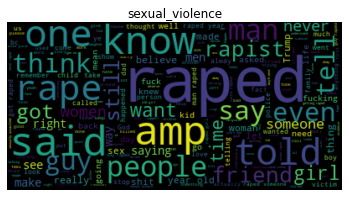

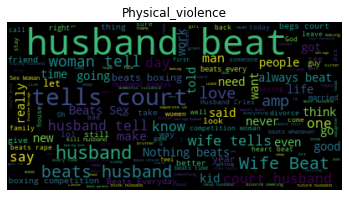

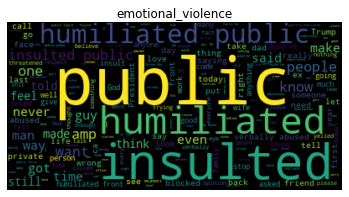

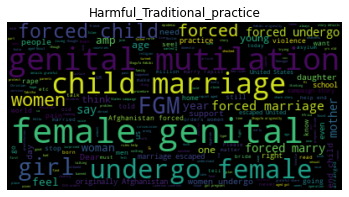

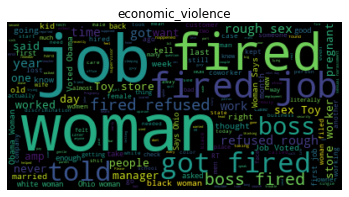

In [ ]:
df_train['cleaned_tweet'] = cleaned_tweets 

sentiment = list(df_train['type'].unique())

for i in sentiment:
  violence = df_train[df_train['type'] == i]

# To concatenate strings with a specific separator
  violence_string = pd.Series(violence.cleaned_tweet).str.cat(sep=' ')
  violence_string = WordCloud().generate(violence_string)
  plt.imshow(violence_string, interpolation='bilinear')
  plt.axis('off')
  plt.title(i)
  plt.show()

## b) Data transforms

In [ ]:
#encoding classes
df_train = df_train.astype({'type':'category'})

In [ ]:
df_train.info()

In [ ]:
# To get the the codes corresponding to each class.
df_train.type.cat.codes

# 4) Evaluate Algorithm

Using Deep Learning

In [ ]:
vocab_size = 5000
max_length = 240
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(cleaned_tweets)


training_sequences = tokenizer.texts_to_sequences(cleaned_tweets)
padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences, padding='post')

In [ ]:
padded = np.array(padded)
y = df_train.type.cat.codes
y = np.array(y)

In [ ]:
labels, counts = np.unique(y, return_counts=True)
labels, counts

(array([0, 1, 2, 3, 4], dtype=int8),
 array([  188,  5946,   217,   651, 32648]))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(padded,y, test_size = 0.3, stratify = y, random_state = 78 )

In [ ]:
labels, counts = np.unique(y, return_counts=True)
W = (1/counts)*(len(y)/5)
W

array([42.18085106,  1.33366969, 36.5437788 , 12.1812596 ,  0.2428939 ])

In [ ]:
counts, labels

(array([  188,  5946,   217,   651, 32648]),
 array([0, 1, 2, 3, 4], dtype=int8))

In [ ]:
class_weight = { 
                0:W[0],   
                1:W[1], 
                2:W[2],
                3:W[3],
                4:W[4]
                }
class_weight 

{0: 42.180851063829785,
 1: 1.3336696939118735,
 2: 36.54377880184332,
 3: 12.181259600614439,
 4: 0.2428938985542759}

In [ ]:
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(123)

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, 64),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.6)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(lr = 3e-4),metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='min'),
            tf.keras.callbacks.ModelCheckpoint(filepath='/content/trial.h5', monitor='val_loss', mode='min', save_best_only=True)]
model.fit(X_train, y_train, validation_data=(X_val,y_val), class_weight= class_weight, batch_size= 32, epochs = 100, callbacks=callback)

In [ ]:
model.summary()

In [ ]:
# To get the best weights corresponding to lowest validation loss.
model = tf.keras.models.load_model('/content/yarab.h5')

In [ ]:
y_prob = model.predict(X_val)

#To get Class Vector

prediction = []


for i in y_prob:
    prediction.append(np.argmax(i))

y_pred = np.array(prediction)

0.9989911727616646


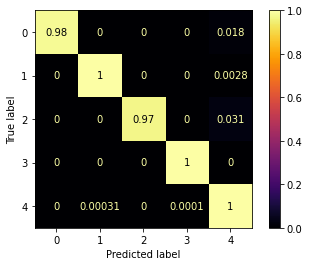

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val,y_pred))

cm = confusion_matrix(y_val, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= np.array(['0','1','2','3','4']) )
disp.plot(cmap='inferno')

## a) Prediction on test dataset

In [ ]:
df_test = pd.read_csv('/content/')
df_test.head(20)

,Tweet_ID,tweet
0,ID_0095QL4S,"because he was my boyfriend, and if I said no,..."
1,ID_00DREW5O,"lol no, I'm telling you it's not legal. It's l..."
2,ID_00E9F5X9,Somalia's semi-autonomous Puntland region has ...
3,ID_00G9OSKZ,University of Cape Coast students being robbed...
4,ID_00HU96U6,"""Somebody came up behind him and stabbed him i..."
5,ID_00IJ4SAW,"Sending you hugs. I was raped by a boyfriend,s..."
6,ID_00J80GL8,he stabbed you with a knife
7,ID_00L0E289,MY FKNG TEACHER HUMILIATED ME AGAIN SHE PREACH...
8,ID_00N24MZN,1988 I was anally raped while I was asleep by ...
9,ID_00V2TOUW,29/9/20:A rape victim was cremated without the...


In [ ]:
cleaned_test_tweets = clean_data(df_test.tweet, True, False, True, True, True)

In [ ]:
cleaned_test_tweets

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(cleaned_test_tweets)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
testing_padded = np.array(testing_padded)

In [ ]:
y_prob = model.predict(testing_padded)

#To get Class Vector

prediction = []


for i in y_prob:
    prediction.append(np.argmax(i))

y_test = np.array(prediction)

In [ ]:
sample_sub = pd.read_csv('/content/SampleSubmission.csv')

In [ ]:
sample_sub['type'] = y_test

In [ ]:
sample_sub['type'] = sample_sub['type'].map({0:'Harmful_Traditional_practice',       
                        1:'physical_violence',  
                        2:'economic_violence',  
                        3:'emotional_violence',
                        4:'sexual_violence'})

In [ ]:
sample_sub.head()

In [ ]:
sample_sub.to_csv('/content/bngrb.csv', index = False)